Frequency frame conversion casatools and astropy

In [1]:
# Imports
import os
import numpy as np
from astropy.coordinates import EarthLocation, SkyCoord, SpectralCoord
from astropy.time import Time
import astropy.units as u
from casatools import table, quanta, measures

measures_update ... acquiring the lock ... 
  ... connecting to ftp.astron.nl ...
  ... downloading WSRT_Measures_20251006-160001.ztar from ASTRON server to /remote/home/inna.muzychenko/.casa/data ...
  ... measures data updated at /remote/home/inna.muzychenko/.casa/data


Why we convert frames

TOPO (what the telescope sees) is time-dependent because of Earth’s rotation and orbit. Converting to LSRK/LSRD/BARY removes that time-dependent Doppler term so spectra from different times/observatories become comparable.
Motion between source and observer causes frequency shifts via the Doppler effect. 
When a source (black dot) is at rest (panel a), it emits concentric waves of constant wavelength; observers receive the waves at the emitted frequency. 
But if the source moves (panel b), waves are compressed ahead (toward observer A) and stretched behind (away from observer C). Observer A thus sees a shorter wavelength (higher frequency) – a blueshift – while C sees a longer wavelength (lower frequency) – a redshift.


In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://openstax.org/apps/image-cdn/v1/f=webp/apps/archive/20250522.165258/resources/2e31d65d9eef6dd9d8a5fd17863d6d4d54e2cc02")

In radio astronomy, most motion-induced frequency shifts are small (Earth’s orbital speed 30 km/s gives $$\Delta f / f \sim 10^{-4}$$), but they are critically important for precision work. 
Earth’s rotation (hundreds of m/s) and orbital motion around the Sun introduce daily and annual Doppler shifts. 
The Sun’s motion around the Galaxy and random stellar motions also shift source frequencies.

Interesting, need to see more
Pulsars and spacecraft: Earth’s rotation and orbital motion cause pulsar signal frequencies to vary daily and annually. Precision timing analyses remove these by converting topocentric times to the barycentric frame (“barycentering”). 
Similarly, spacecraft communication frequencies are Doppler-tracked to account for Earth-spacecraft relative motion.

What we must provide

- observer (location)
- source direction (RA/Dec)
- observation epoch/time. 

Note: CASA also needs IERS / Earth orientation data to do the conversion precisely. If you haven’t updated IERS, run the casaconfig / measures_update() steps we below. The warning might affect calculation precision.

To convert the frequency we first need to get the data and a relevant information from the tables.

In [3]:
tb = table()
qa = quanta()
me = measures()

In [4]:
ms_name = "../day2_TDEM0003_10s_norx"

---------------------------
Read metadata from MS
---------------------------

In [6]:
# OBSERVATION: Start time
tb.open(f"{ms_name}/OBSERVATION")
time_range = tb.getcol("TIME_RANGE")[0][0]  # in seconds
time_unit = tb.getcolkeywords("TIME_RANGE").get("QuantumUnits", ["s", "s"])[0]  # usually "s"
start_time = qa.quantity(time_range, time_unit)
start_time_mjd = start_time['value'] / 86400.0  # convert to days

# Print out the value of timezone
keywords = tb.getcolkeywords("TIME_RANGE")
time_ref_val = keywords.get("MEASINFO", {}).get("Ref")
print(time_ref_val)

# Clean up
tb.close()

UTC


True

In [19]:
# FIELD: Phase direction (RA, Dec)
tb.open(f"{ms_name}/FIELD")

phase_dir = tb.getcol("PHASE_DIR")
direction_unit = 'rad'

ra_rad = float(phase_dir[0, 0, 0])
dec_rad = float(phase_dir[1, 0, 0])
ra_quantity = qa.quantity(ra_rad, direction_unit)
dec_quantity = qa.quantity(dec_rad, direction_unit)
direction_rad = [ra_quantity, dec_quantity]

phase_dir_ref = tb.getcolkeywords("PHASE_DIR")["MEASINFO"]["Ref"]
print(phase_dir_ref)

# Clean up
tb.close()

J2000


True

In [18]:
# ANTENNA: Antenna position
tb.open(f"{ms_name}/ANTENNA")
position_val = tb.getcol("POSITION")[:, 0]
position_units = tb.getcolkeywords("POSITION").get("QuantumUnits", ["m", "m", "m"])
position = [qa.quantity(position_val[i], position_units[i]) for i in range(3)]

position_ref = tb.getcolkeywords("POSITION")["MEASINFO"]["Ref"]
print(position_ref)

# Clean up
tb.close()

ITRF


True

In [9]:
# SPECTRAL_WINDOW: Reference frequency
tb.open(f"{ms_name}/SPECTRAL_WINDOW")
ref_freq_val = tb.getcol("REF_FREQUENCY")[0]  # Hz
ref_freq_unit = tb.getcolkeywords("REF_FREQUENCY").get("QuantumUnits", ["Hz"])[0]
ref_freq = qa.quantity(ref_freq_val, ref_freq_unit)

# Read the MEAS_FREQ_REF column (this is an integer code for the frame)
freq_ref_val_int = tb.getcol("MEAS_FREQ_REF")

# Get the mapping from integer to frame name
freq_ref_map = tb.getcolkeywords("CHAN_FREQ")
freq_frame_ref = freq_ref_map["MEASINFO"]["TabRefTypes"][freq_ref_val_int[0]]

# Print out
print("MEAS_FREQ_REF values in the MS:", freq_ref_val_int)
print(freq_ref_map)
print("Mapping info from keywords:", freq_frame_ref)

# pos = tb.getcolkeywords("POSITION")
# print(pos)

# Clean up
tb.close()

MEAS_FREQ_REF values in the MS: [5 5]
{'MEASINFO': {'TabRefCodes': array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint64), 'TabRefTypes': array(['REST', 'LSRK', 'LSRD', 'BARY', 'GEO', 'TOPO', 'GALACTO', 'LGROUP',
       'CMB'], dtype='<U7'), 'VarRefCol': 'MEAS_FREQ_REF', 'type': 'frequency'}, 'QuantumUnits': array(['Hz'], dtype='<U2')}
Mapping info from keywords: TOPO


True

In [10]:
# Print what we have
print(f"Time (MJD): {start_time}")
print(f"Direction (RA, Dec): {direction_rad}")
print(f"Observer position (X, Y, Z): {position}")
print(f"Reference frequency: {ref_freq}")

Time (MJD): {'unit': 's', 'value': 4778968169.360001}
Direction (RA, Dec): [{'unit': 'rad', 'value': 2.6529016266}, {'unit': 'rad', 'value': 0.1309799403}]
Observer position (X, Y, Z): [{'unit': 'm', 'value': -1601710.017}, {'unit': 'm', 'value': -5042006.9282}, {'unit': 'm', 'value': 3554602.3556}]
Reference frequency: {'unit': 'Hz', 'value': 36387229474.54398}


---------------------------
Frequency measure creation and conversions
---------------------------
We create a frequency measure in the TOPO (topocentric) frame because the MS stores
frequencies as seen at the telescope. Then we convert to other frames.

Note: me.frequency(reference, quantity) accepts a reference frame and a quantity
(string like '1420MHz' or a qa.quantity). The result is a CASA measure record.


In [ ]:
# Make a frame
# Set the observer (ALMA)
#me.doframe(me.observatory('ALMA'))
me.doframe({'m0': position[0],
            'm1': position[1],
            'm2': position[2],
            'refer': position_ref,
            'type': 'position'})

# Set the source direction (RA, Dec) in J2000
# Assuming you have 'direction_rad' extracted (RA, Dec in rad)
me.doframe({'m0': direction_rad[0],
            'm1': direction_rad[1],
            'refer': phase_dir_ref, 'type': 'direction'})

# Set the time of observation
# Assuming you have 'start_time' already computed from the MS (in days)
me.doframe({'m0': start_time,
            'type': 'epoch', 'refer': time_ref_val})
freq_topo_casa = me.frequency(freq_frame_ref,ref_freq)

Convert to commonly-used frames:
- TOPO  : Topocentric - frequency as seen at the telescope (time-dependent)
- LSRK : Local Standard of Rest, kinematic, removes observer motion using kinematic solar motion (commonly used in radio astronomy)
- LSRD : Local Standard of Rest, dynamical, alternate LSR convention
- BARY : Solar-System barycenter, removes all Solar-system motions (useful for absolute timing/velocities)

In [12]:
converted_freqs_casa_lsrk = me.measure(freq_topo_casa, 'LSRK')
converted_freqs_casa_lsrd = me.measure(freq_topo_casa, 'LSRD')
converted_freqs_casa_bary = me.measure(freq_topo_casa, 'BARY')

# converted_freqs_casa_rest = me.measure(freq_topo_casa, 'REST') #not enough information
# Converting to the source rest frame requires the source redshift or systemic velocity. 
# Without that additional information me.measure(...,'REST') cannot determine the rest frequency uniquely.

# To do

#converted_freqs_casa_geo = me.measure(freq_topo_casa, 'GEO')
#converted_freqs_casa_galacto = me.measure(freq_topo_casa, 'GALACTO')
#converted_freqs_casa_lgroup = me.measure(freq_topo_casa, 'LGROUP')
#converted_freqs_casa_cmb = me.measure(freq_topo_casa, 'CMP')


In [13]:
print(converted_freqs_casa_lsrk)
print(converted_freqs_casa_lsrd)
print(converted_freqs_casa_bary)

{'m0': {'unit': 'Hz', 'value': 36391288076.242546}, 'refer': 'LSRK', 'type': 'frequency'}
{'m0': {'unit': 'Hz', 'value': 36391069971.84389}, 'refer': 'LSRD', 'type': 'frequency'}
{'m0': {'unit': 'Hz', 'value': 36390437401.93788}, 'refer': 'BARY', 'type': 'frequency'}


In [21]:
#In CASA, the J2000 reference frame corresponds to the FK5 system with the equinox at J2000.0.
#In Astropy, the equivalent of J2000 is FK5(equinox='J2000'), not 'icrs'.
#The ICRS frame (International Celestial Reference System) is very close to J2000 (they differ by a few tens of milliarcseconds), 
# but strictly speaking, they’re not the same.
from astropy.coordinates import FK5

# Set location
# Possible to simply specify ALMA but we have coordinates, so utilaze that
#location = EarthLocation.of_site("ALMA")
location = EarthLocation.from_geocentric(
    position_val[0] * u.m,
    position_val[1] * u.m,
    position_val[2] * u.m,
)

obstime = Time(start_time_mjd, format="mjd", scale=time_ref_val.lower())
alma = location.get_itrs(obstime=obstime)


# Source sky coordinates (J2000)
skycoord = SkyCoord(
    ra=ra_rad * u.rad,
    dec=dec_rad * u.rad,
    frame=FK5(equinox=phase_dir_ref)
)
# skycoord = SkyCoord(ra=ra_rad * u.rad,
#                     dec=dec_rad * u.rad,
#                     frame='icrs')

observer_coord = SkyCoord(alma) 
freq_topo_astropy = SpectralCoord(
    ref_freq_val * u.Hz,
    observer=observer_coord,
    target=skycoord,
    doppler_convention='radio'
)

# --- 5. Convert to other frames ---

converted_freqs_astropy_lsrk = freq_topo_astropy.with_observer_stationary_relative_to('lsrk')
converted_freqs_astropy_lsrd = freq_topo_astropy.with_observer_stationary_relative_to('lsrd')
converted_freqs_astropy_bary = freq_topo_astropy.with_observer_stationary_relative_to('icrs')
#'icrs' is used here as a stand-in for barycentric ICRS stationarity - I assume 'BARY' in CASA
# To rest
# converted_freqs_astropy_rest = freq_topo_astropy.to_rest()

In [22]:
# An example of accesig a value from record
val_casa = me.getvalue(converted_freqs_casa_lsrk)['m0']['value']
print(val_casa)

36391288076.242546


In [23]:
# An example of getting value from SpectralCoord
val_astropy = converted_freqs_astropy_lsrk.to(u.Hz).value 
print(val_astropy)

36391288072.66383


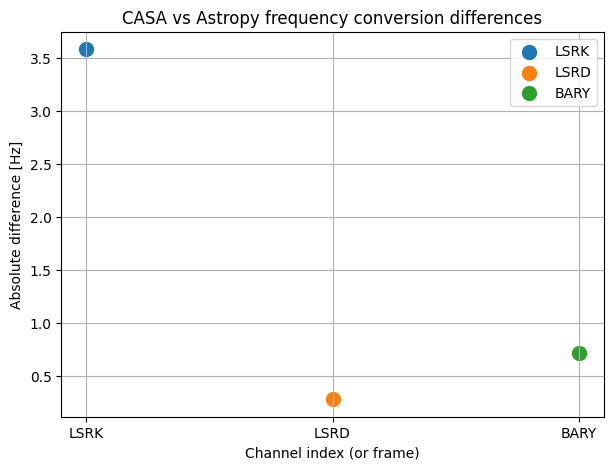

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

# CASA results
freq_casa_lsrk_hz  = me.getvalue(converted_freqs_casa_lsrk)['m0']['value']
freq_casa_lsrd_hz  = me.getvalue(converted_freqs_casa_lsrd)['m0']['value']
freq_casa_bary_hz  = me.getvalue(converted_freqs_casa_bary)['m0']['value']

# Astropy results
freq_astropy_lsrk_hz  = converted_freqs_astropy_lsrk.to(u.Hz).value
freq_astropy_lsrd_hz  = converted_freqs_astropy_lsrd.to(u.Hz).value
freq_astropy_bary_hz  = converted_freqs_astropy_bary.to(u.Hz).value

# Absolute differences
diffs_abs = {
    "LSRK": np.abs(freq_casa_lsrk_hz - freq_astropy_lsrk_hz),
    "LSRD": np.abs(freq_casa_lsrd_hz - freq_astropy_lsrd_hz),
    "BARY": np.abs(freq_casa_bary_hz - freq_astropy_bary_hz),
}

# --- Plot the result ---
plt.figure(figsize=(7,5))

for label, diff in diffs_abs.items():
    # Works for both scalars and arrays
    if np.ndim(diff) == 0:
        plt.scatter([label], [diff], label=label, s=100)
    else:
        plt.plot(diff, label=label)

plt.xlabel("Channel index (or frame)")
plt.ylabel("Absolute difference [Hz]")
plt.title("CASA vs Astropy frequency conversion differences")
plt.legend()
plt.grid(True)
plt.show()


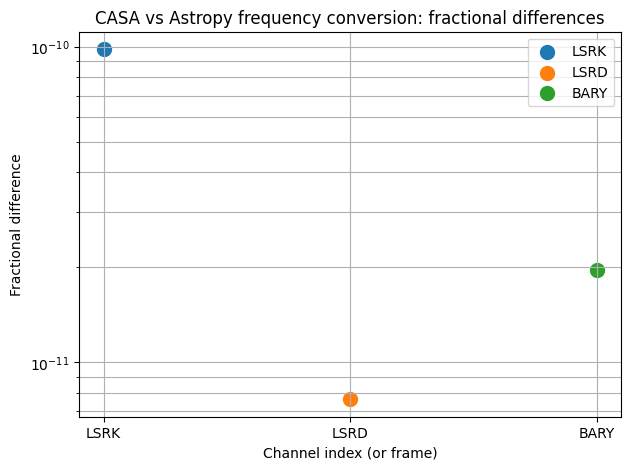

In [25]:
diffs_frac = {
    "LSRK": diffs_abs["LSRK"] / freq_astropy_lsrk_hz,
    "LSRD": diffs_abs["LSRD"] / freq_astropy_lsrd_hz,
    "BARY": diffs_abs["BARY"] / freq_astropy_bary_hz,
}

# --- Plot fractional difference ---
plt.figure(figsize=(7,5))
for label, diff in diffs_frac.items():
    if np.ndim(diff) == 0:
        plt.scatter([label], [diff], label=label, s=100)
    else:
        plt.plot(diff, label=label)
plt.xlabel("Channel index (or frame)")
plt.ylabel("Fractional difference")
plt.title("CASA vs Astropy frequency conversion: fractional differences")
plt.yscale("log")  # fractional differences are usually tiny → log scale is clearer
plt.legend()
plt.grid(True, which="both")
plt.show()

In [17]:
# In case of warning during the freq conversion
from casaconfig import pull_data, measures_update

# Fetch initial runtime data (geodetic tables, leap seconds, etc.)
pull_data()

# Update just the measures data (IERS Earth orientation parameters, TAI_UTC, etc.)
measures_update()


pull_data: version is already at the expected version and force is False. Nothing was changed
measures_update: version installed or checked less than 1 day ago, nothing updated or checked
